# **Node Classification with DeepSNAP**

This is a tutorial for DeepSNAP node classification.

In this tutorial, we will at first introduce the basics of DeepSNAP node classification.

Then we will perform node classification by using DeepSNAP on the `Cora` dataset.

You might need to **sequentially run all the cells in each section**.

# Installation

Before running the cells, please go to the `Runtime` and `Change runtime type` to `GPU`.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q deepsnap

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 68 kB 3.0 MB/s 


# DeepSNAP Node Classification Basics

In this section, we will go through the basics of the DeepSNAP node classification.

## Setup

In [2]:
import torch
import warnings
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import DataLoader

# Disable DeepSNAP warnings for better printout in the tutorial
warnings.filterwarnings("ignore")

## Transductive Node Classification

We will use the [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html) in the example.


The graph has 34 nodes and 78 edges


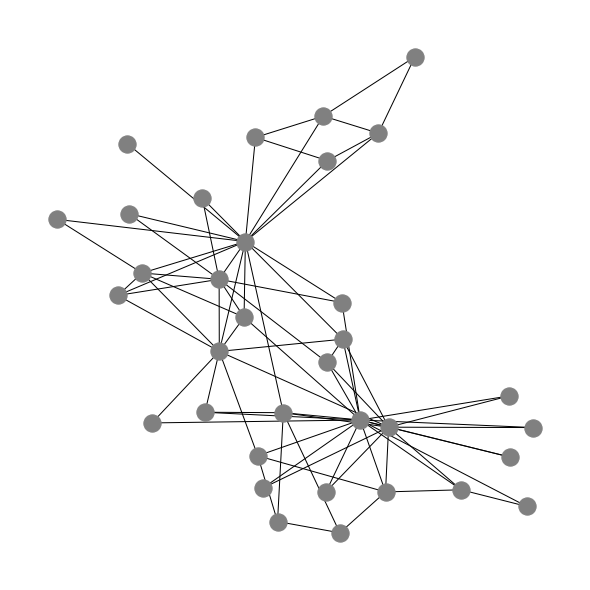

In [3]:
G = nx.karate_club_graph()
print("The graph has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color="grey")
plt.show()

In [4]:
def visualize(colors, title=None):
    plt.figure(figsize=(8, 8))
    if title is not None:
        plt.title(title, fontsize=20)
    nodes = nx.draw_networkx_nodes(H, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=colors)
    nodes.set_edgecolor('black')
    edges = nx.draw_networkx_edges(H, pos=pos)
    plt.scatter([],[], c='blue', label='Mr. Hi', edgecolors="black", s=140)
    plt.scatter([],[], c='red', label='Officer', edgecolors="black", s=140)
    if "grey" in colors:
        plt.scatter([],[], c='grey', label='N/A', edgecolors="black", s=140)
    plt.legend(prop={'size': 15}, handletextpad=0)
    plt.show()

Let's visualize the graph at first!

As shown in the plot below, the karate club graph has two communities, which are visualized with two different colors (blue and red).

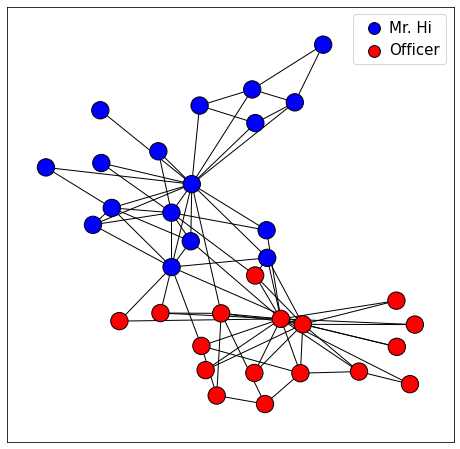

In [5]:
H = deepcopy(G)
node_color = {}
community_map = {}
for node in H.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        node_color[node[0]] = "blue"
        community_map[node[0]] = 0
    else:
        node_color[node[0]] = "red"
        community_map[node[0]] = 1
nx.classes.function.set_node_attributes(H, community_map, name='node_label')
nx.classes.function.set_node_attributes(H, node_color, name='color')
colors = nx.get_node_attributes(H, 'color').values()
visualize(colors)

Following is an example for DeepSNAP node classification with dataset creation, dataset split (random) and results visualization on the karate club graph.



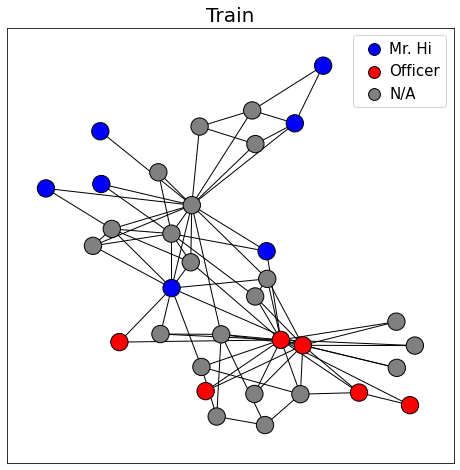

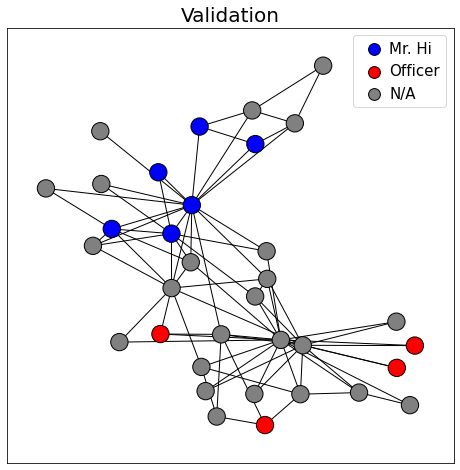

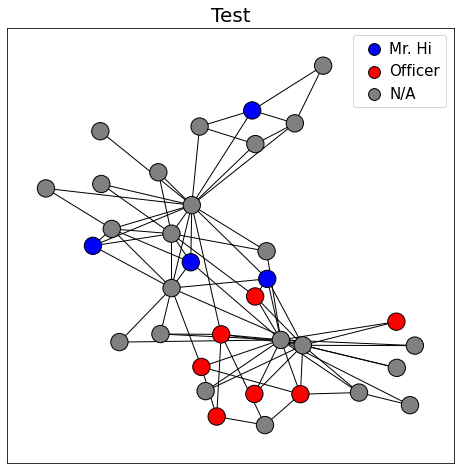

In [6]:
# Create the DeepSNAP dataset by setting the task to node (node classification)
dg_dataset = GraphDataset([H], task="node")

# Random split to train, validation and test sets
dataset_train, dataset_val, dataset_test = dg_dataset.split(split_ratio=[0.4, 0.3, 0.3])
set_name = ["Train", "Validation", "Test"]
for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    node_set = set()
    colors = []
    data = dataset[0]
    for node in data.node_label_index:
        node_set.add(node.item())
    for node in H.nodes():
        if node not in node_set:
            colors.append("grey")
        else:
            colors.append(node_color[node])
    visualize(colors, title=set_name[i])

Plots above show the dataset split results.

Blue and red nodes are the nodes splitted to each of the train, validation and test set. Grey nodes mean that the nodes are not available in that set.

# Node Classification on Cora Graph

Now let's perform transductive node classification task on the `Cora` graph by using the DeepSNAP!

In this example, instead of splitting the dataset randomly, we use the `Cora` dataset original fixed node split.

## Setup

In [7]:
import copy
import torch
import torch.nn as nn
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid
from torch.utils.data import DataLoader
from torch_geometric.nn import SAGEConv

## A Simple GNN Model

In [17]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(input_size, hidden_size))
        for l in range(self.num_layers - 1):
            self.convs.append(SAGEConv(hidden_size, hidden_size))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
        x = self.convs[-1](x, edge_index)
        # x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Train and Test

In [18]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)

    for epoch in range(args['epochs']):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        test_acc = test(test_loader, model, device)
        print("Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}".format(
            epoch + 1, train_acc, val_acc, test_acc, total_loss))

def test(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

## Start Training!

Let's start training!

In [19]:
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 128,
    "epochs" : 100,
    "lr" : 0.01,
    "num_layers": 2,
    "dataset" : "Cora",
}

pyg_dataset = Planetoid('./tmp/cora', args["dataset"])

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, fixed_split=True)

dataset_train, dataset_val, dataset_test = \
    GraphDataset(graphs_train, task='node'), GraphDataset(graphs_val,task='node'), \
    GraphDataset(graphs_test, task='node')

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=1)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=1)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=1)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels

train(train_loader, val_loader,test_loader, args, num_node_features, num_classes, args["device"])

GNN(
  (convs): ModuleList(
    (0): SAGEConv(1433, 128, aggr=mean)
    (1): SAGEConv(128, 128, aggr=mean)
  )
  (post_mp): Linear(in_features=128, out_features=7, bias=True)
)
Epoch 1: Train: 1.0000, Validation: 0.7240. Test: 0.7240, Loss: 1.9474
Epoch 2: Train: 1.0000, Validation: 0.7120. Test: 0.7390, Loss: 1.5592
Epoch 3: Train: 1.0000, Validation: 0.7720. Test: 0.7740, Loss: 0.7069
Epoch 4: Train: 1.0000, Validation: 0.7420. Test: 0.7560, Loss: 0.1185
Epoch 5: Train: 1.0000, Validation: 0.7580. Test: 0.7710, Loss: 0.0145
Epoch 6: Train: 1.0000, Validation: 0.7520. Test: 0.7750, Loss: 0.0013
Epoch 7: Train: 1.0000, Validation: 0.7520. Test: 0.7790, Loss: 0.0001
Epoch 8: Train: 1.0000, Validation: 0.7520. Test: 0.7770, Loss: 0.0000
Epoch 9: Train: 1.0000, Validation: 0.7520. Test: 0.7730, Loss: 0.0000
Epoch 10: Train: 1.0000, Validation: 0.7520. Test: 0.7760, Loss: 0.0000
Epoch 11: Train: 1.0000, Validation: 0.7520. Test: 0.7700, Loss: 0.0000
Epoch 12: Train: 1.0000, Validation: 0.7

More node classification examples please see the [examples/node_classification](https://github.com/snap-stanford/deepsnap/tree/master/examples/node_classification) folder.

[Next: Link Prediction with DeepSNAP](https://colab.research.google.com/drive/1ycdlJuse7l2De7wi51lFd_nCuaWgVABc?usp=sharing)